# AE_train

https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import pathlib
import os
from scipy.signal import hilbert
from sklearn.preprocessing import StandardScaler

In [2]:
googledrive = True

In [3]:
# ドライブのマウント

if googledrive:
    from google.colab import drive
    drive.mount('/content/drive/')
    # 牧野さん以外の方はMyDriveへ共有フォルダのショートカットを作るとマウントできるようになります。
    %cd "/content/drive/MyDrive/AIQ2021_CoCreation_MaNiAC/sample_code/AEsample_ebikazuki/"

pwd = pathlib.Path(".")
print("pwd:",pwd.resolve())
sorted([v for v in pwd.glob("*") if ".ipynb_checkpoints" not in str(v)])


Mounted at /content/drive/
[Errno 2] No such file or directory: '/content/drive/MyDrive/AIQ2021_CoCreation_MaNiAC/sample_code/AEsample_ebikazuki/'
/content
pwd: /content


[PosixPath('.config'), PosixPath('drive'), PosixPath('sample_data')]

## 学習データ、検証データのファイル名取得

In [4]:
TRAIN=pwd/'data'/'train'
TEST=pwd/'data'/'test'
CV_CNT=5

In [ ]:
train_normal = sorted(TRAIN.glob('normal/*.csv'))
train_anormal = sorted(TRAIN.glob('anomaly/*.csv'))
test = sorted(TEST.glob('*.csv'))

print(len(train_normal),len(train_anormal),len(test))


50 50 49


## 乱数シード

In [ ]:
import random
# 乱数のシードを設定
SEED=1234

np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## データ可視化



In [ ]:
COLUMNS=[f'ch_{x}' for x in range(7)]

In [ ]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def load_data(file):
    return pd.read_csv(file, header=None, names=COLUMNS).interpolate().fillna(0).values

def to_powspec(y):
    N = 15000
    yf = fft(y)
    return 2.0/N * np.abs(yf[0:len(y)//2])

def plot_powspec(file):
    data = load_data(file)
    for ix in range(data.shape[1]):
        fig, ax = plt.subplots(1,2,figsize=(16,8))
        # エンベロープ処理
        y = np.abs(hilbert(data[:, ix]))
        ax[0].set_title(f'{file},{ix}')
        ax[0].plot(y) 
        ax[1].plot(to_powspec(y))
        plt.show(fig)
    return


### 正常データ
左:エンベロープ処理した波形、右:パワースペクトル

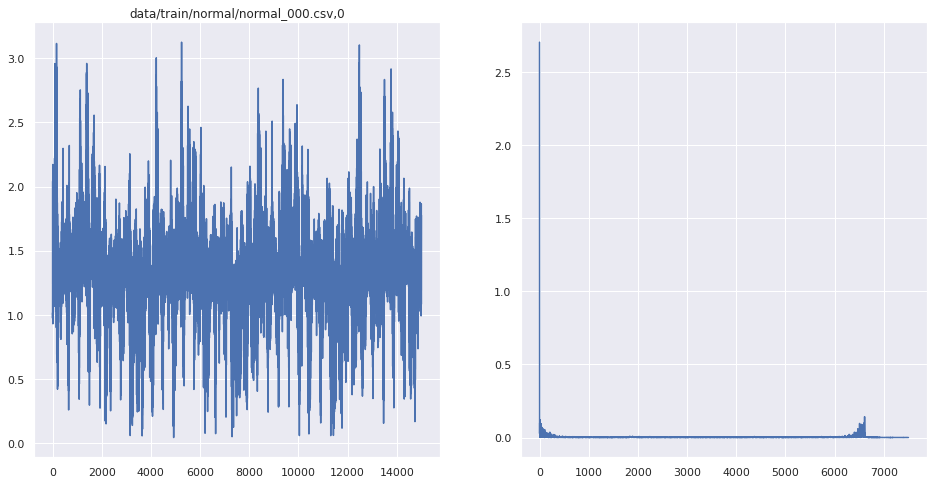

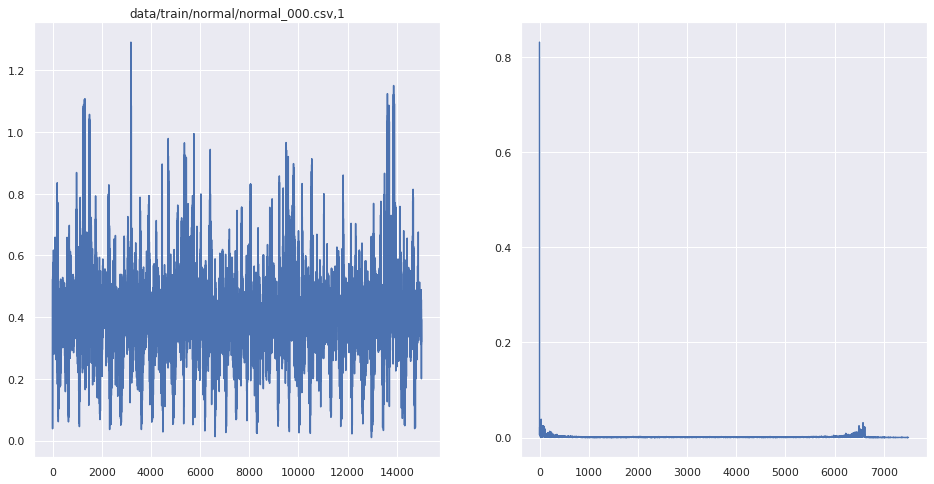

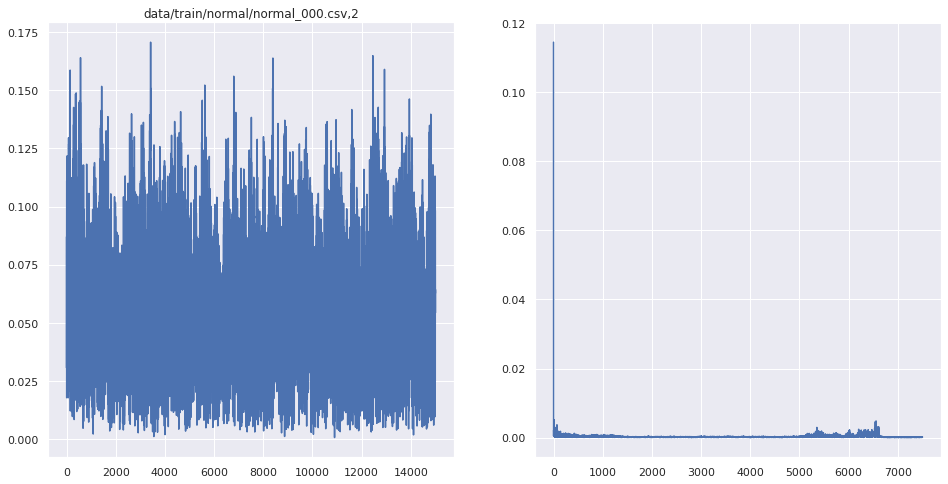

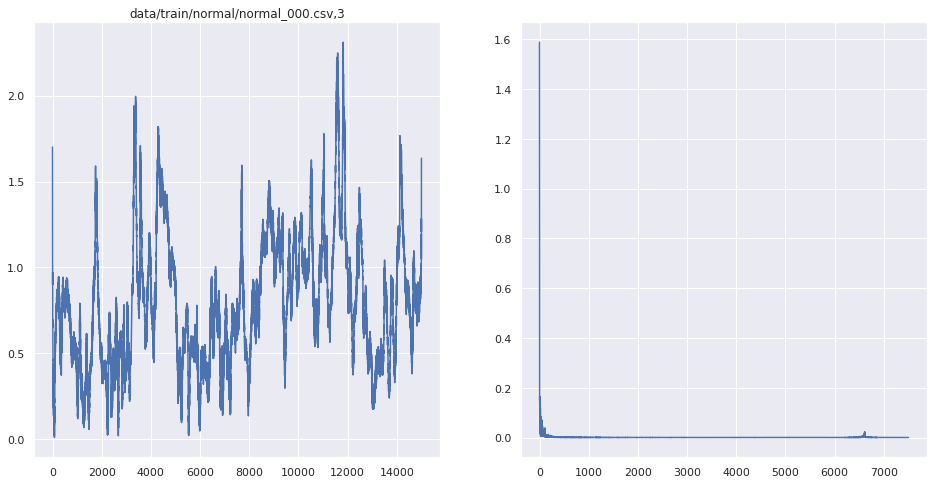

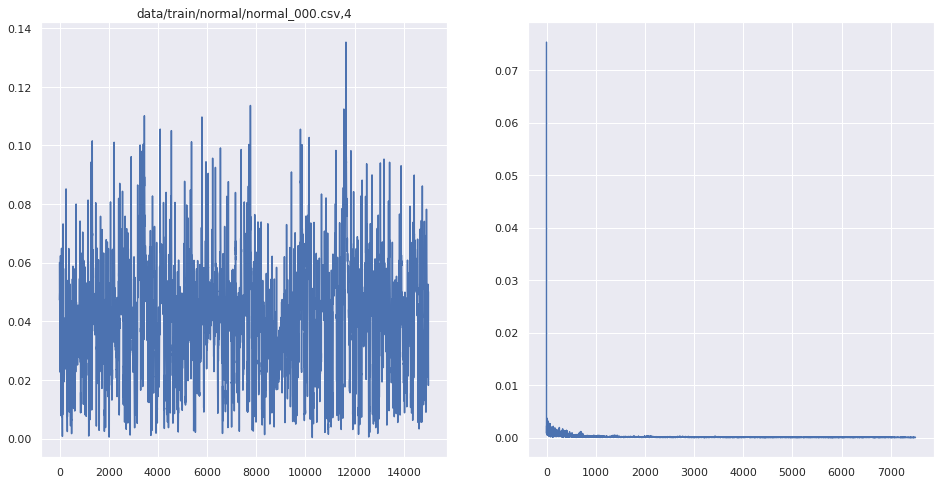

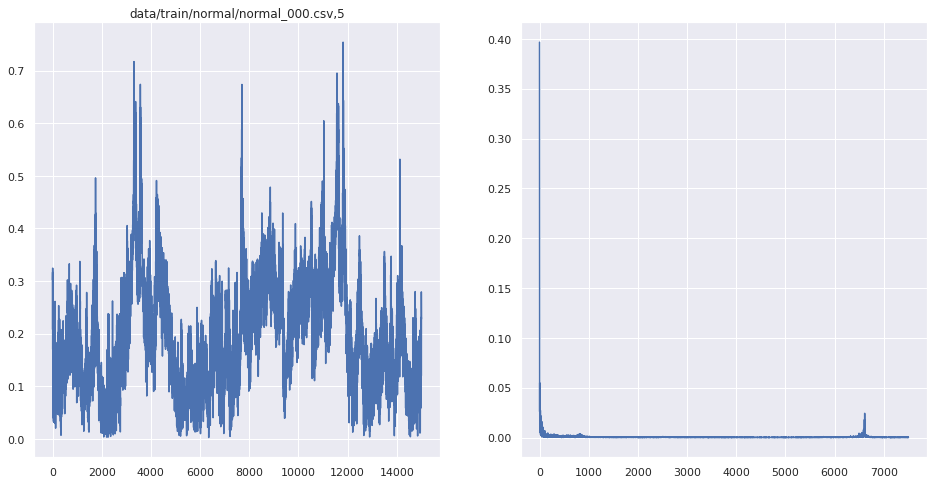

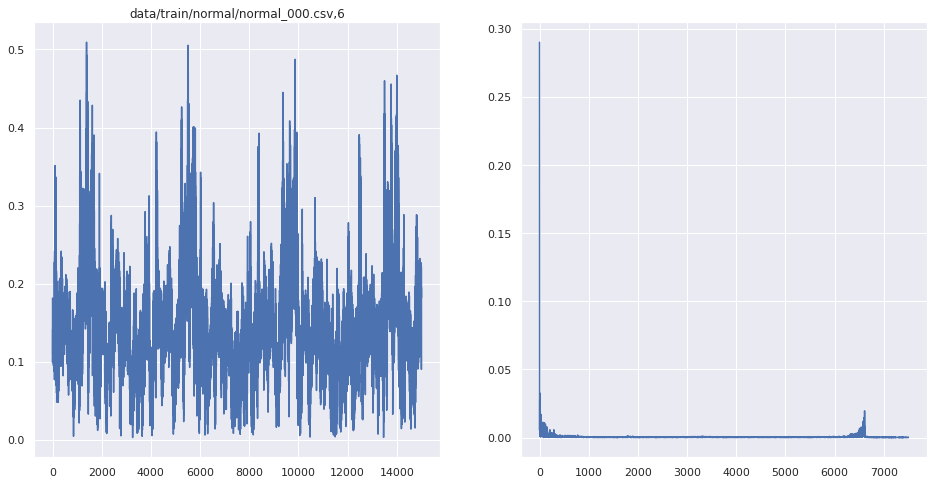

In [ ]:
plot_powspec(train_normal[0]) 

### 異常データ


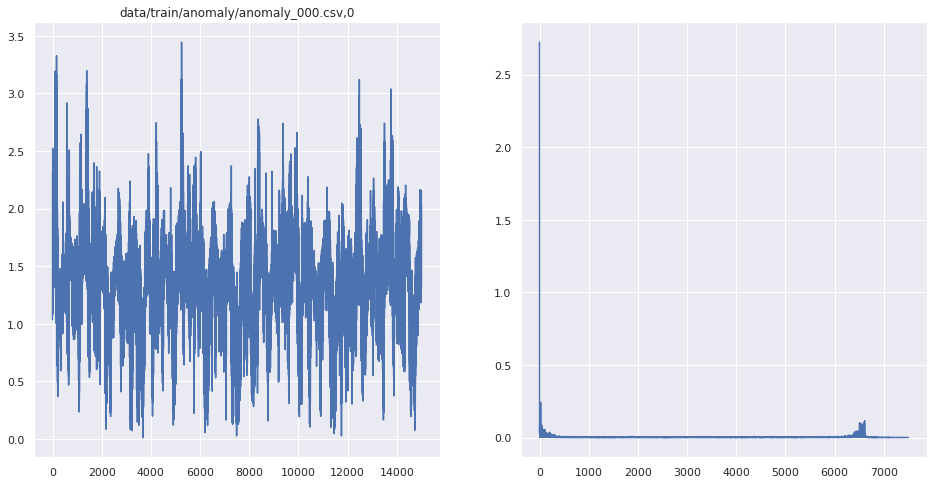

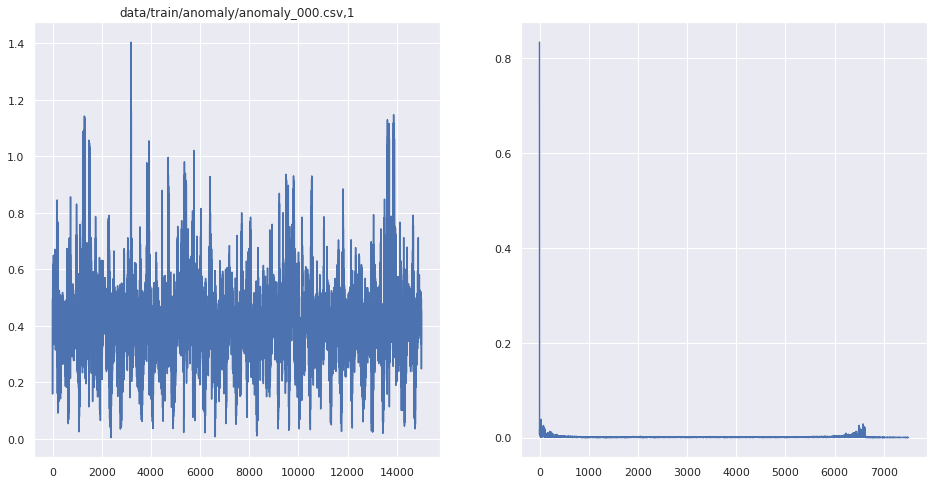

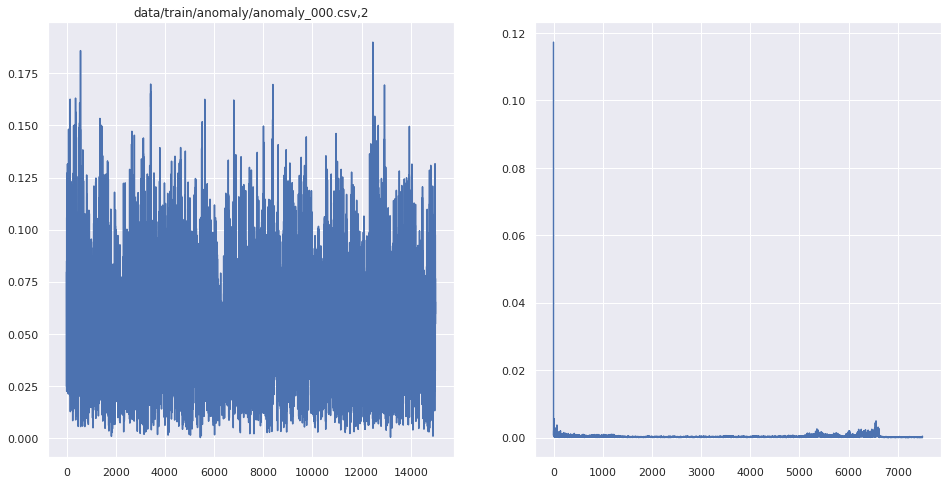

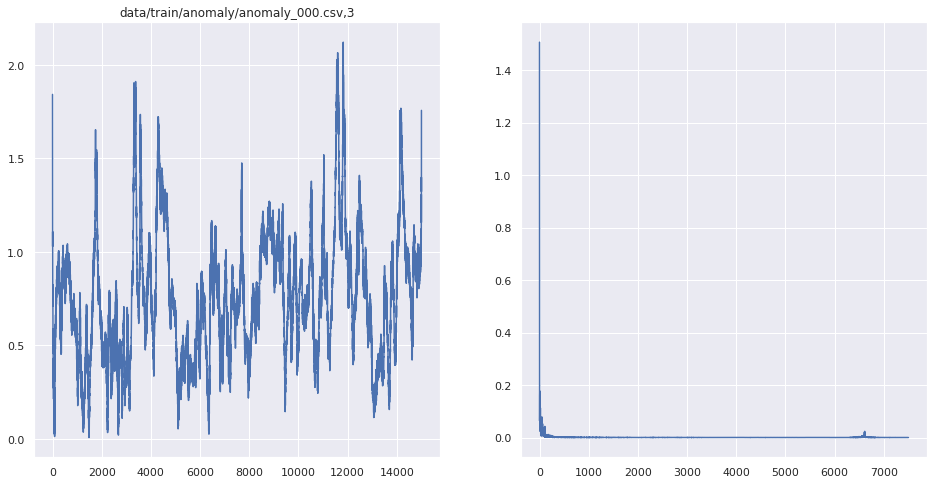

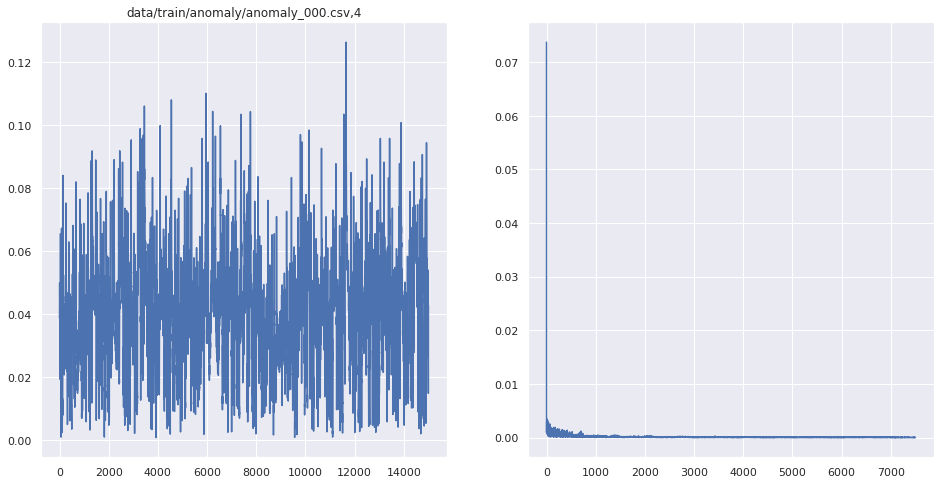

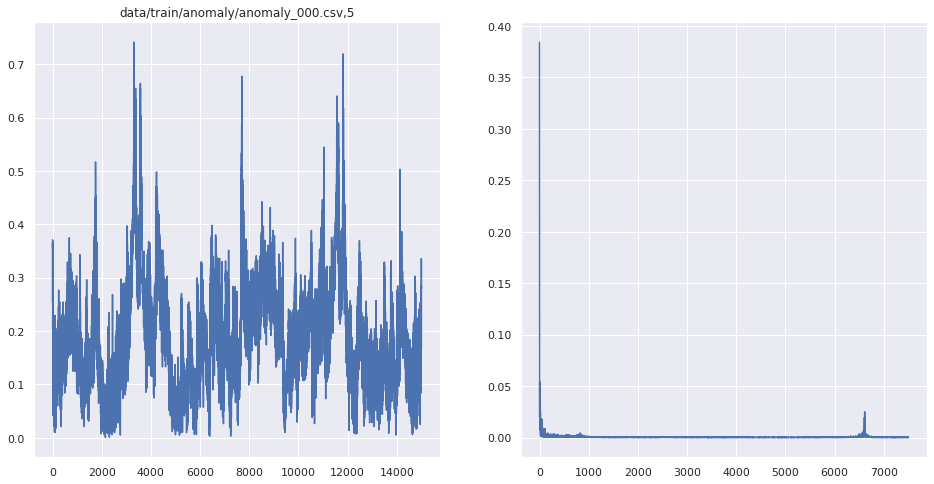

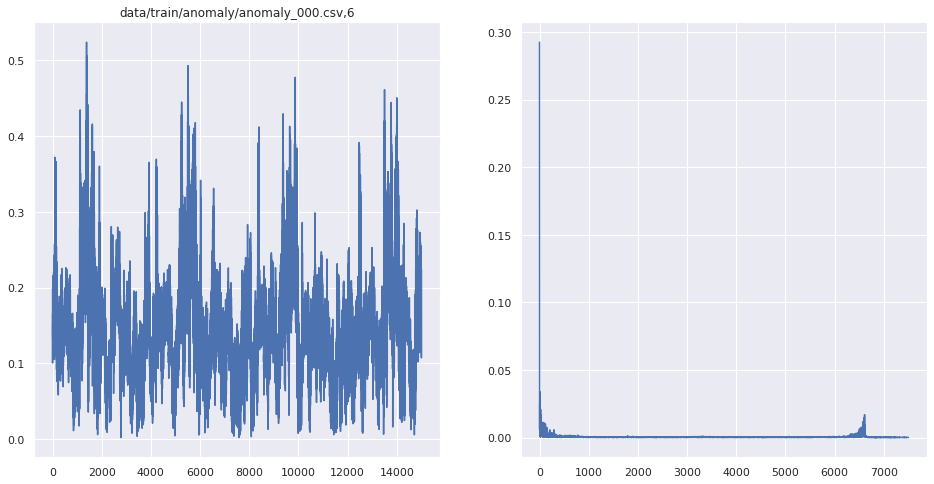

In [ ]:
plot_powspec(train_anormal[0])   

## 学習データの準備

In [ ]:


def make_dataset(files,ch):
    dataset=[]
    for file in files:
      data_all = pd.read_csv(file, header=None, names=COLUMNS).interpolate().fillna(0).values
      data_env = np.abs(hilbert(data_all[:,ch]))
      data_fft = to_powspec(data_env)
      # データ量を1/10に畳み込み
      data_conv = data_fft.reshape(-1, 10).mean(axis=1)
      dataset.append(data_conv)
    dataset = np.array(dataset)
    return dataset

x_train = make_dataset(train_normal,6)
x_train.shape

(50, 750)

In [ ]:
# # https://www.codexa.net/normalization-python/
# # https://teratail.com/questions/218412

# from sklearn.preprocessing import StandardScaler

# def standerdize(x):
  
#   # 標準化のクラスを定義
#   sc = StandardScaler()
  
#   #fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
#   data_std = sc.fit_transform(x)
  
#   return data_std, sc

# x_train, sc = standerdize(x_train)
# x_train.shape


In [ ]:
# https://www.codexa.net/normalization-python/
# https://teratail.com/questions/218412

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_train.shape



(50, 750)

## Training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim  = x_train.shape[1]

input = keras.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim)(decoded)

autoencoder = keras.Model(input, decoded)
optimizer= keras.optimizers.Adam(lr=0.001) #0.001
autoencoder.compile(optimizer=optimizer, loss='mse')

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                #validation_data=(x_test, x_test)
                )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
7/7 [==============================] - 1s 5ms/step - loss: 1.0091
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 0.9976
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.9897
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.9726
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.9279
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.8559
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.7880
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.7325
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6898
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6542
Epoch 11/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6289
Epoch 12/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6039
Epoch 13/100
7/7 [==============================] - 0s 4ms/st

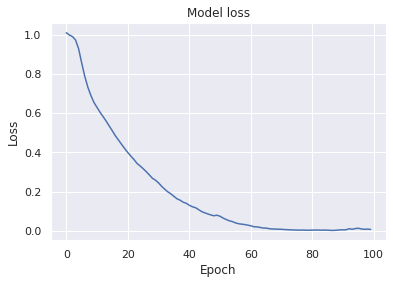

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 異常検知の精度確認

In [ ]:
x_normal = make_dataset(train_normal,6)
x_normal = sc.transform(x_normal )

x_anormal = make_dataset(train_anormal,6)
x_anormal = sc.transform(x_anormal )

print(x_normal.shape)
print(x_anormal.shape)

(50, 750)
(50, 750)


In [ ]:
def autoencorder_score(x):
  pred = autoencoder.predict(x)
  score = np.mean(np.square(x - pred), axis=1)
  return score

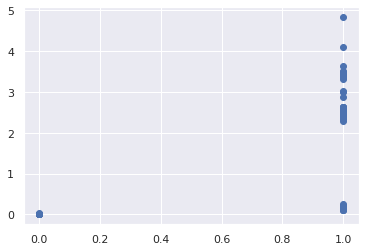

In [ ]:
normal_score = autoencorder_score(x_normal)
anormal_score = autoencorder_score(x_anormal)

y = np.concatenate([normal_score, anormal_score])
x = np.concatenate([
                    np.zeros(len(normal_score)),
                    np.ones(len(anormal_score))
                    ])

plt.scatter(x, y)

In [ ]:
threshold = 0.7
# 正解率
print("accuracy:",np.count_nonzero(anormal_score > threshold)/len(anormal_score))

accuracy: 0.52


### 提出ファイル

In [ ]:
# df_test = convert_wav_feature_1(df_test)
# df_test['key'] = df_test['file'].apply(lambda x:os.path.basename(x))
# for ix, mod in enumerate(models):
#     df_test[f'pred_svc_{ix}'] = mod.predict_proba(sc.transform(df_test[new_columns]))[:,1]
# pred_columns = [f'pred_svc_{ix}' for ix in range(len(models))]
# df_test['final_pred'] = (df_test[pred_columns].agg('mean', axis=1) > 0.4).astype(int)
# df_test[['key','final_pred']].to_csv('submission2.csv', index=False, header=None)